In [3]:
# Ici il manque les marques bcp de point à corriger


from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, round, avg, sum, max as spark_max, lit, 
    datediff, row_number, when, dayofweek, hour, countDistinct
)
from pyspark.sql.window import Window
import pandas as pd

# Initialisation de la session Spark
spark = SparkSession.builder.appName("E-Amazing Data Processing").getOrCreate()

# Définir le chemin des fichiers
output_path = "./data/filtered_df_output.parquet"

# Charger et préparer les données
def load_and_prepare_data(path):
    return spark.read.parquet(path).withColumn("event_time", col("event_time").cast("timestamp"))

# Ajouter des colonnes supplémentaires
def add_additional_columns(df):
    return df.withColumn("event_day_of_week", dayofweek("event_time")) \
             .withColumn("event_hour", hour("event_time"))

# Convertir les jours de la semaine numériques en chaînes de caractères
def convert_day_of_week(df, day_col):
    return df.withColumn(day_col,
        when(col(day_col) == 1, "Dimanche")
        .when(col(day_col) == 2, "Lundi")
        .when(col(day_col) == 3, "Mardi")
        .when(col(day_col) == 4, "Mercredi")
        .when(col(day_col) == 5, "Jeudi")
        .when(col(day_col) == 6, "Vendredi")
        .when(col(day_col) == 7, "Samedi")
    )

# Convertir les heures en périodes de la journée
def convert_time_of_day(df, hour_col):
    return df.withColumn("time_of_day",
        when(col(hour_col).between(5, 11), "matin")
        .when(col(hour_col).between(12, 16), "après-midi")
        .when(col(hour_col).between(17, 23), "soir")
        .otherwise("nuit")
    )

# Calculer les statistiques par utilisateur et période
def compute_user_stats(df, period):
    def event_agg(event_type, alias):
        return df.filter(col("event_type") == event_type).groupBy("user_id").agg(count("*").alias(alias))
    
    views = event_agg("view", f"number_of_views_{period}")
    carts = event_agg("cart", f"number_of_carts_{period}")
    purchases = df.filter(col("event_type") == "purchase").groupBy("user_id").agg(
        count("*").alias(f"count_products_{period}"),
        round(avg("price"), 2).alias(f"avg_price_{period}")
    )
    sessions = df.groupBy("user_id").agg(countDistinct("user_session").alias(f"number_of_sessions_{period}"))
    
    return views.join(carts, "user_id").join(purchases, "user_id").join(sessions, "user_id")

# Calculer les autres statistiques sans brand_loyalty
def compute_other_stats(df, now):
    last_purchase = df.filter(col("event_type") == "purchase").groupBy("user_id").agg(spark_max("event_time").alias("last_purchase_temp"))
    first_purchase = last_purchase.withColumnRenamed("last_purchase_temp", "first_purchase_temp")

    purchase_period = first_purchase.join(last_purchase, "user_id") \
                                    .withColumn("purchase_period_days", datediff(col("last_purchase_temp"), col("first_purchase_temp")) + 1)
    total_purchases = df.filter(col("event_type") == "purchase").groupBy("user_id").agg(count("*").alias("total_purchases"))
    days_since_last_purchase = last_purchase.withColumn("days_since_last_purchase", datediff(lit(now), col("last_purchase_temp")))
    total_purchase_value = df.filter(col("event_type") == "purchase").groupBy("user_id").agg(round(sum("price"), 2).alias("total_purchase_value"))

    cart_abandonments = df.filter(col("event_type") == "cart").groupBy("user_id").agg(count("*").alias("cart_count")) \
                          .join(df.filter(col("event_type") == "purchase").groupBy("user_id").agg(count("*").alias("purchase_count")), "user_id") \
                          .withColumn("cart_abandonments", when(col("cart_count") > col("purchase_count"), col("cart_count") - col("purchase_count")).otherwise(0))

    return days_since_last_purchase, total_purchase_value, cart_abandonments

# Calculer les préférences utilisateur et les moments d'activité
def compute_user_preferences_and_activity(df):
    def most_frequent(df, group_col, alias):
        return df.withColumn("rank", row_number().over(Window.partitionBy("user_id").orderBy(col(group_col).desc()))) \
                 .filter(col("rank") == 1).drop("rank").select("user_id", col(group_col).alias(alias))

    preferred_brand = most_frequent(df.filter(col("event_type") == "purchase").groupBy("user_id", "brand").agg(count("*").alias("brand_purchases")), "brand_purchases", "preferred_brand")
    preferred_category = most_frequent(df.filter(col("event_type") == "purchase").groupBy("user_id", "category_code").agg(count("*").alias("category_purchases")), "category_purchases", "preferred_category")

    most_active_time = df.withColumn("event_hour", hour("event_time"))  # Extraire l'heure
    most_active_time = convert_time_of_day(most_active_time, "event_hour")  # Convertir en période de la journée
    most_active_time = most_active_time.groupBy("user_id", "time_of_day").agg(count("*").alias("time_activity"))  # Agréger par période de la journée
    
    most_active_time = most_frequent(most_active_time, "time_activity", "most_active_time")
    
    # Calculer most_active_day en ne filtrant pas les valeurs nulles
    most_active_day = df.groupBy("user_id", "event_day_of_week").agg(count("*").alias("day_activity")) \
                        .withColumn("rank", row_number().over(Window.partitionBy("user_id").orderBy(col("day_activity").desc()))) \
                        .filter(col("rank") == 1).drop("rank").select("user_id", col("event_day_of_week").alias("most_active_day"))

    # Convertir les jours de la semaine numériques en chaînes de caractères
    most_active_day = convert_day_of_week(most_active_day, "most_active_day")

    return preferred_brand, preferred_category, most_active_time, most_active_day

# Fonction pour vérifier et éliminer les doublons sur user_id
def check_for_duplicates(df):
    duplicate_count = df.groupBy("user_id").count().filter(col("count") > 1).count()
    if duplicate_count > 0:
        raise ValueError(f"Le DataFrame final contient {duplicate_count} doublons pour 'user_id'.")
    return df

# Fonction principale de traitement
def main():
    # Chargement et préparation des données
    filtered_df = load_and_prepare_data(output_path)
    filtered_df = add_additional_columns(filtered_df)

    # Définir les périodes de temps
    now = filtered_df.select(spark_max("event_time")).collect()[0][0]
    periods = {"2m": pd.DateOffset(months=2), "5m": pd.DateOffset(months=5), "7m": pd.DateOffset(months=7)}

    # Calculer les statistiques pour chaque période
    stats_all = None
    for period, offset in periods.items():
        filtered_period_df = filtered_df.filter(col("event_time") >= lit(now - offset))
        period_stats = compute_user_stats(filtered_period_df, period)
        stats_all = period_stats if stats_all is None else stats_all.join(period_stats, "user_id")

    # Calculer les autres statistiques sans brand_loyalty
    days_since_last_purchase, total_purchase_value, cart_abandonments = compute_other_stats(filtered_df, now)

    # Calculer les préférences (marque, catégorie) et les moments d'activité
    preferred_brand, preferred_category, most_active_time, most_active_day = compute_user_preferences_and_activity(filtered_df)

    # Finaliser et combiner les résultats
    user_stats_df = stats_all.join(days_since_last_purchase, "user_id") \
                             .join(total_purchase_value, "user_id") \
                             .join(cart_abandonments, "user_id") \
                             .join(preferred_brand, "user_id") \
                             .join(preferred_category, "user_id") \
                             .join(most_active_time, "user_id") \
                             .join(most_active_day, "user_id")

    # Vérification des doublons
    user_stats_df = check_for_duplicates(user_stats_df)

    # Enregistrer user_stats_df dans un fichier Parquet
    user_stats_df.write.mode("overwrite").parquet("./data/user_stats_df.parquet")
    user_stats_df.show()

# Exécuter le script principal
if __name__ == "__main__":
    main()


24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/28 10:34:56 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+------------------+------------------+-----------------+------------+---------------------+------------------+------------------+-----------------+------------+---------------------+------------------+------------------+-----------------+------------+---------------------+-------------------+------------------------+--------------------+----------+--------------+-----------------+---------------+------------------+----------------+---------------+
|  user_id|number_of_views_2m|number_of_carts_2m|count_products_2m|avg_price_2m|number_of_sessions_2m|number_of_views_5m|number_of_carts_5m|count_products_5m|avg_price_5m|number_of_sessions_5m|number_of_views_7m|number_of_carts_7m|count_products_7m|avg_price_7m|number_of_sessions_7m| last_purchase_temp|days_since_last_purchase|total_purchase_value|cart_count|purchase_count|cart_abandonments|preferred_brand|preferred_category|most_active_time|most_active_day|
+---------+------------------+------------------+-----------------+-------

24/08/28 10:47:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, hour, count, row_number, desc
from pyspark.sql.window import Window
import pandas as pd

# Supposons que filtered_df soit le DataFrame contenant les événements
output_path = "./data/filtered_df_output.parquet"
filtered_df=pd.read_parquet(output_path)
# 1. Ajouter une colonne pour extraire l'heure de l'événement
filtered_df = filtered_df.withColumn("event_hour", hour(col("event_time")))

# 2. Convertir l'heure en période de la journée
filtered_df = filtered_df.withColumn("time_of_day",
    when(col("event_hour").between(5, 11), "matin")
    .when(col("event_hour").between(12, 16), "après-midi")
    .when(col("event_hour").between(17, 23), "soir")
    .otherwise("nuit")
)

# 3. Calculer la période la plus active pour chaque utilisateur
most_active_time_df = filtered_df.groupBy("user_id", "time_of_day").agg(count("*").alias("activity_count"))

# 4. Utiliser row_number pour identifier la période la plus active
window_spec = Window.partitionBy("user_id").orderBy(desc("activity_count"))
most_active_time_df = most_active_time_df.withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") == 1).drop("rank", "activity_count")

# 5. Joindre la période la plus active avec les autres statistiques de l'utilisateur
user_stats_df = user_stats_df.join(most_active_time_df, on="user_id", how="left")

# Le résultat final devrait avoir 'most_active_time' avec des étiquettes catégorielles
user_stats_df.select("user_id", "most_active_time").show()


: 

: 

: 

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, hour, count, row_number, desc
from pyspark.sql.window import Window
import pandas as pd

# Suppose filtered_df is the DataFrame containing the events
output_path = "./data/filtered_df_output.parquet"
filtered_df=pd.read_parquet(output_path)
# Load a sample for testing
filtered_df_sample = filtered_df.sample(fraction=0.1)  # Use a sample of 10% for testing

# 1. Add a column to extract the hour of the event
filtered_df_sample = filtered_df_sample.withColumn("event_hour", hour(col("event_time")))

# 2. Convert the hour to time of day
filtered_df_sample = filtered_df_sample.withColumn("time_of_day",
    when(col("event_hour").between(5, 11), "matin")
    .when(col("event_hour").between(12, 16), "après-midi")
    .when(col("event_hour").between(17, 23), "soir")
    .otherwise("nuit")
)

# 3. Calculate the most active period for each user
most_active_time_df = filtered_df_sample.groupBy("user_id", "time_of_day").agg(count("*").alias("activity_count"))

# 4. Use row_number to identify the most active period
window_spec = Window.partitionBy("user_id").orderBy(desc("activity_count"))
most_active_time_df = most_active_time_df.withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") == 1).drop("rank", "activity_count")

# 5. Join the most active period with the user's other statistics
user_stats_df = user_stats_df.join(most_active_time_df, on="user_id", how="left")

# Display the final result with 'most_active_time' as categorical labels
user_stats_df.select("user_id", "most_active_time").show()


: 

: 

: 

In [16]:
import dask.dataframe as dd

# Charger les données avec Dask
output_path = "./data/filtered_df_output.parquet"
df = dd.read_parquet(output_path)

# Convertir les heures en période de la journée
def time_of_day(hour):
    if 5 <= hour <= 11:
        return 'matin'
    elif 12 <= hour <= 16:
        return 'après-midi'
    elif 17 <= hour <= 23:
        return 'soir'
    else:
        return 'nuit'

# Ajouter une colonne pour extraire l'heure de l'événement
df['event_hour'] = df['event_time'].dt.hour

# Appliquer la fonction sur toute la colonne
df['most_active_time'] = df['event_hour'].apply(time_of_day, meta=('event_hour', 'object'))

# Calculer la période la plus active pour chaque utilisateur
most_active_time_df = df.groupby(['user_id', 'most_active_time']).size().compute().reset_index(name='activity_count')

# Identifier la période la plus active pour chaque utilisateur
most_active_time_df['rank'] = most_active_time_df.groupby('user_id')['activity_count'].rank(method='first', ascending=False)
most_active_time_df = most_active_time_df[most_active_time_df['rank'] == 1].drop(columns=['rank', 'activity_count'])

# Charger user_stats_df avec Dask (en supposant qu'il soit aussi dans un fichier Parquet)
user_stats_df_path = "./data/user_stats_df.parquet"
user_stats_df = dd.read_parquet(user_stats_df_path)



# Supprimer la colonne 'most_active_time' s'il existe déjà dans user_stats_df
if 'most_active_time' in user_stats_df.columns:
    user_stats_df = user_stats_df.drop(columns=['most_active_time'])

# Réaliser la jointure
user_stats_df = user_stats_df.merge(most_active_time_df, on='user_id', how='inner')

# Vérification des colonnes
print(user_stats_df.columns)


Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'count_products_2m', 'avg_price_2m', 'number_of_sessions_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'count_products_5m',
       'avg_price_5m', 'number_of_sessions_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'count_products_7m', 'avg_price_7m',
       'number_of_sessions_7m', 'last_purchase_temp',
       'days_since_last_purchase', 'total_purchase_value', 'cart_count',
       'purchase_count', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_day', 'most_active_time'],
      dtype='object')


     user_id  number_of_views_2m  number_of_carts_2m  count_products_2m  \
0  359242441                  75                   4                  1   
1  438263431                 138                   4                  3   
2  439490571                  25                   2                  1   
3  469107971                   2                   1                  1   
4  472393541                   4                   1                  1   
5  473616651                  21                   3                  2   
6  478219391                  16                   8                  1   
7  480165611                   6                   2                  2   
8  487774501                   3                   1                  1   
9  490293331                 101                  21                 16   

   avg_price_2m  number_of_sessions_2m  number_of_views_5m  \
0         56.63                      9                  75   
1         81.70                     46            

In [19]:
user_stats_df.dtypes


user_id                               int32
number_of_views_2m                    int64
number_of_carts_2m                    int64
count_products_2m                     int64
avg_price_2m                        float64
number_of_sessions_2m                 int64
number_of_views_5m                    int64
number_of_carts_5m                    int64
count_products_5m                     int64
avg_price_5m                        float64
number_of_sessions_5m                 int64
number_of_views_7m                    int64
number_of_carts_7m                    int64
count_products_7m                     int64
avg_price_7m                        float64
number_of_sessions_7m                 int64
last_purchase_temp           datetime64[ns]
days_since_last_purchase              int32
total_purchase_value                float64
cart_count                            int64
purchase_count                        int64
cart_abandonments                     int64
preferred_brand                 

In [20]:
user_stats_df.columns

Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'count_products_2m', 'avg_price_2m', 'number_of_sessions_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'count_products_5m',
       'avg_price_5m', 'number_of_sessions_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'count_products_7m', 'avg_price_7m',
       'number_of_sessions_7m', 'last_purchase_temp',
       'days_since_last_purchase', 'total_purchase_value', 'cart_count',
       'purchase_count', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_day', 'most_active_time'],
      dtype='object')

In [14]:
df.dtypes

user_id                              int32
number_of_views_2m                   int64
number_of_carts_2m                   int64
count_products_2m                    int64
avg_price_2m                       float64
number_of_sessions_2m                int64
number_of_views_5m                   int64
number_of_carts_5m                   int64
count_products_5m                    int64
avg_price_5m                       float64
number_of_sessions_5m                int64
number_of_views_7m                   int64
number_of_carts_7m                   int64
count_products_7m                    int64
avg_price_7m                       float64
number_of_sessions_7m                int64
last_purchase_temp          datetime64[ns]
days_since_last_purchase             int32
total_purchase_value               float64
cart_count                           int64
purchase_count                       int64
cart_abandonments                    int64
preferred_brand                      int64
preferred_c

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum as spark_sum

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("E-Amazing Data Processing with Brand Loyalty") \
    .getOrCreate()

# Charger le DataFrame (par exemple, filtered_df)
user_stats_df = spark.read.parquet("./data/user_stats_df.parquet")

# Calcul du score de fidélité à une marque avec l'indice de Simpson
brand_purchases_by_user = user_stats_df.groupBy("user_id", "brand").agg(count("*").alias("brand_purchases"))

# Calcul du total des achats par utilisateur
total_purchases_by_user = brand_purchases_by_user.groupBy("user_id").agg(spark_sum("brand_purchases").alias("total_purchases"))

# Joindre pour calculer l'indice de Simpson
simpson_index_df = brand_purchases_by_user.join(total_purchases_by_user, on="user_id") \
    .withColumn("simpson_component", (col("brand_purchases") * (col("brand_purchases") - 1)) / (col("total_purchases") * (col("total_purchases") - 1)))

# Agrégation pour obtenir l'indice de Simpson par utilisateur
brand_loyalty_df = simpson_index_df.groupBy("user_id").agg(spark_sum("simpson_component").alias("brand_loyalty"))

# Joindre avec user_stats_df pour intégrer ce nouveau score
user_stats_df = user_stats_df.join(brand_loyalty_df, on="user_id", how="left")

# Sauvegarder le DataFrame final avec le nouveau score de fidélité
user_stats_df.write.mode("overwrite").parquet("./data/user2_stats_df_with_new_loyalty.parquet")

# Afficher les résultats
user_stats_df.show()

# Arrêter la session Spark
spark.stop()


/tmp/ipykernel_2284/1830764217.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', color='blue')


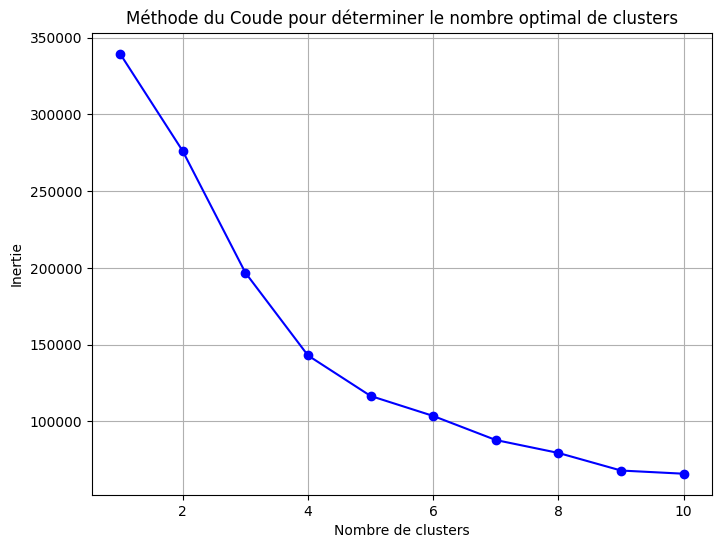

Inertie (somme des distances au carré des points aux centroïdes) : 142993.68462737565


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Charger le DataFrame user_stats_df
df = pd.read_parquet("data/user_stats_df.parquet")

# Variables à utiliser pour le K-means
variables_kmeans = [
    'total_purchase_value', 
    'number_of_sessions_7m', 
    'number_of_carts_7m', 
    'purchase_count' # A remplacer par total_purchase
]

# Extraire les données pour les variables sélectionnées
X = df[variables_kmeans]

# Standardisation des données
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Créer un pipeline avec StandardScaler et KMeans
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Étape 1 : Standardisation des données
    ('kmeans', KMeans(n_clusters=4, random_state=42))  # Étape 2 : Clustering KMeans
])

# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_standardized)
    inertia.append(kmeans.inertia_)

# Tracer la méthode du coude
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-', color='blue')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()

# Ajuster le pipeline aux données et prédire les clusters
df['user_segment'] = pipeline.fit_predict(X)

# Map des segments à des labels de graduation d'achat
segment_labels = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Very High'}
df['user_segment'] = df['user_segment'].map(segment_labels)

kmeans_step = pipeline.named_steps['kmeans']  # Accéder à l'étape KMeans du pipeline
print(f"Inertie (somme des distances au carré des points aux centroïdes) : {kmeans_step.inertia_}")

# Sauvegarder le DataFrame avec la nouvelle colonne en format Parquet
df.to_parquet("./data/user_stats_segmented_df.parquet", index=False)




**Inertie** : L'inertie (kmeans_step.inertia_) mesure la qualité du clustering. Elle représente la somme des distances au carré des points à leur centroïde le plus proche. Une inertie plus faible indique un meilleur clustering (les points sont plus proches de leurs centroïdes).

In [ ]:
# Compromis entre le nombre de centroïde et la somme des distance.
# Créer un pipeline avec StandardScaler et KMeans
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Étape 1 : Standardisation des données
    ('kmeans', KMeans(n_clusters=4, random_state=42))  # Étape 2 : Clustering KMeans
])

# Ajuster le pipeline aux données
pipeline.fit(X)

# Afficher l'inertie (le score du KMeans)
kmeans_step = pipeline.named_steps['kmeans']  # Accéder à l'étape KMeans du pipeline
print(f"Inertie (somme des distances au carré des points aux centroïdes) : {kmeans_step.inertia_}")


Inertie (somme des distances au carré des points aux centroïdes) : 93261.32739760079


In [ ]:
dfs=pd.read_parquet('data/user_stats_segmented_df.parquet')
dfs['user_segment'].unique()

array(['Low', 'High', 'Medium', 'Very High'], dtype=object)

24/08/26 13:08:26 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 6584277 ms exceeds timeout 120000 ms
24/08/26 13:08:28 WARN SparkContext: Killing executors is not supported by current scheduler.
24/08/26 13:08:28 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

In [3]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd

# Initialiser Dask
client = Client()

# Charger les données avec Dask
output_path = "./data/filtered_df_output.parquet"
df = dd.read_parquet(output_path)

# Convertir les heures en périodes de la journée
def time_of_day(hour):
    if 5 <= hour <= 11:
        return 'matin'
    elif 12 <= hour <= 16:
        return 'après-midi'
    elif 17 <= hour <= 23:
        return 'soir'
    else:
        return 'nuit'

# Ajouter une colonne pour extraire l'heure de l'événement
df['event_hour'] = df['event_time'].dt.hour

# Appliquer la fonction sur toute la colonne
df['most_active_time'] = df['event_hour'].apply(time_of_day, meta=('event_hour', 'object'))

# Fonction pour calculer les statistiques pour une période donnée
def compute_user_stats(df, period_label, period_offset):
    period_df = df[df['event_time'] >= df['event_time'].max() - pd.DateOffset(months=period_offset)]

    # Calculer les vues, les paniers et les achats
    number_of_views = period_df[period_df['event_type'] == 'view'].groupby('user_id').size().rename(f'number_of_views_{period_label}')
    number_of_carts = period_df[period_df['event_type'] == 'cart'].groupby('user_id').size().rename(f'number_of_carts_{period_label}')
    count_products = period_df[period_df['event_type'] == 'purchase'].groupby('user_id').size().rename(f'count_products_{period_label}')

    # Calculer le prix moyen des achats
    avg_price = period_df[period_df['event_type'] == 'purchase'].groupby('user_id')['price'].mean().rename(f'avg_price_{period_label}')

    # Calculer le nombre de sessions
    number_of_sessions = period_df.groupby('user_id')['user_session'].nunique().rename(f'number_of_sessions_{period_label}')

    # Fusionner toutes les statistiques
    stats = dd.concat([number_of_views, number_of_carts, count_products, avg_price, number_of_sessions], axis=1)

    return stats

# Calculer les statistiques pour les périodes de 2, 5, et 7 mois
stats_2m = compute_user_stats(df, '2m', 2)
stats_5m = compute_user_stats(df, '5m', 5)
stats_7m = compute_user_stats(df, '7m', 7)

# Fusionner toutes les statistiques ensemble
user_stats_df = stats_2m.merge(stats_5m, on='user_id', how='outer').merge(stats_7m, on='user_id', how='outer')

# Calculer les statistiques supplémentaires
last_purchase = df[df['event_type'] == 'purchase'].groupby('user_id')['event_time'].max()
days_since_last_purchase = (df['event_time'].max() - last_purchase).dt.days
total_purchase_value = df[df['event_type'] == 'purchase'].groupby('user_id')['price'].sum()

# Ajouter les statistiques supplémentaires au DataFrame
user_stats_df['last_purchase_temp'] = last_purchase
user_stats_df['days_since_last_purchase'] = days_since_last_purchase
user_stats_df['total_purchase_value'] = total_purchase_value

# Calculer les abandons de panier
cart_count = df[df['event_type'] == 'cart'].groupby('user_id').size()
purchase_count = df[df['event_type'] == 'purchase'].groupby('user_id').size()
cart_abandonments = cart_count - purchase_count

# Utiliser .where pour remplacer les valeurs négatives par 0
cart_abandonments = cart_abandonments.where(cart_abandonments >= 0, 0)

user_stats_df['cart_count'] = cart_count
user_stats_df['purchase_count'] = purchase_count
user_stats_df['cart_abandonments'] = cart_abandonments

# Convertir la partie nécessaire en Pandas pour calculer les préférences de marque et de catégorie
df_pandas = df[df['event_type'] == 'purchase'].compute()

# Calculer les préférences de marque
preferred_brand = df_pandas.groupby(['user_id', 'brand']).size().reset_index()
preferred_brand.columns = ['user_id', 'brand', 'count']  # Renommer les colonnes correctement
preferred_brand = preferred_brand.loc[preferred_brand.groupby('user_id')['count'].idxmax()].set_index('user_id')['brand']

# Calculer les préférences de catégorie
preferred_category = df_pandas.groupby(['user_id', 'category_code']).size().reset_index()
preferred_category.columns = ['user_id', 'category_code', 'count']  # Renommer les colonnes correctement
preferred_category = preferred_category.loc[preferred_category.groupby('user_id')['count'].idxmax()].set_index('user_id')['category_code']

# Ajouter les préférences au DataFrame principal
user_stats_df['preferred_brand'] = preferred_brand
user_stats_df['preferred_category'] = preferred_category

# Calculer la période la plus active pour chaque utilisateur
most_active_time_df = df.groupby(['user_id', 'most_active_time']).size().reset_index()
most_active_time_df.columns = ['user_id', 'most_active_time', 'activity_count']  # Renommer les colonnes correctement

# Calculer le rang de l'activité
most_active_time_df['rank'] = most_active_time_df.groupby('user_id')['activity_count'].rank(method='first', ascending=False)

# Filtrer pour ne garder que la période la plus active
most_active_time_df = most_active_time_df[most_active_time_df['rank'] == 1].drop(columns=['rank', 'activity_count'])

# Supprimer la colonne 'most_active_time' s'il existe déjà dans user_stats_df
if 'most_active_time' in user_stats_df.columns:
    user_stats_df = user_stats_df.drop(columns=['most_active_time'])

# Réaliser la jointure
user_stats_df = user_stats_df.merge(most_active_time_df[['user_id', 'most_active_time']], on='user_id', how='inner')

# Vérification des colonnes
print(user_stats_df.columns)

# Afficher les premières lignes
print(user_stats_df.head())

# Optionnel : Sauvegarder le DataFrame final
# user_stats_df.to_parquet('./data/user_stats_df_final.parquet', engine='pyarrow')


/usr/local/lib/python3.9/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43335 instead
  warnings.warn(


AttributeError: 'Column not found: rank'

2024-08-29 19:11:00,184 - distributed.scheduler - WARNING - Worker failed to heartbeat for 561s; attempting restart: <WorkerState 'tcp://127.0.0.1:40249', name: 0, status: running, memory: 0, processing: 0>
2024-08-29 19:11:00,269 - distributed.scheduler - WARNING - Worker failed to heartbeat for 561s; attempting restart: <WorkerState 'tcp://127.0.0.1:40669', name: 2, status: running, memory: 0, processing: 0>
2024-08-29 19:11:00,377 - distributed.scheduler - WARNING - Worker failed to heartbeat for 561s; attempting restart: <WorkerState 'tcp://127.0.0.1:44247', name: 3, status: running, memory: 0, processing: 0>
2024-08-29 19:11:00,381 - distributed.scheduler - WARNING - Worker failed to heartbeat for 561s; attempting restart: <WorkerState 'tcp://127.0.0.1:45749', name: 1, status: running, memory: 0, processing: 0>
2024-08-29 19:11:04,384 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/usr/local/lib/pyth